In [11]:
%env DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
Tue Mar 19 09:52:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:1A:00.0 Off |                  N/A |
| 30%   36C    P8               7W / 250W |      2MiB / 11264MiB |      0%      Default |
|                                         |               

In [3]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [4]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/temp/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/temp/CaloQVAE/')

In [5]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[09:45:21.461] INFO   CaloQVAE                                          Willkommen!
[09:45:21.464] INFO   CaloQVAE                                          Loading configuration.


In [7]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch/QVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

In [8]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [12]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/home/dsogutlu/.local/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[09:52:45.475] INFO   data.dataManager                                  Loading Data
[09:52:56.781] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fda277a7eb0>: 80000 events, 1250 batches
[09:52:56.782] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fda277a7fa0>: 10000 events, 79 batches
[09:52:56.783] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fda277a7ee0>: 10000 events, 79 batches
[09:53:00.124] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2024-03-19 09:53:00,

Initializing NetworkV3


In [13]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[09:54:27.379] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[09:54:27.383] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[09:54:32.847] INFO   engine.engineAtlas                                Setting up engine Atlas.
[09:54:32.850] INFO   engine.engineCaloV3                               Setting up engine Calo.
[09:54:32.851] INFO   engine.engine                                     Setting up default engine.


In [14]:
# config=compose(config_name="config.yaml")
config_2=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config_2, mode='disabled')
modelCreator_2 = ModelCreator(cfg=config_2)
dataMgr_2 = DataManager(cfg=config_2)
#initialise data loaders
dataMgr_2.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr_2.pre_processing()

if config_2.model.activation_fct.lower()=="relu":
    modelCreator_2.default_activation_fct=torch.nn.ReLU()
elif config_2.model.activation_fct.lower()=="tanh":
    modelCreator_2.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator_2.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model_2=modelCreator_2.init_model(dataMgr=dataMgr_2)

#create the NN infrastructure
model_2.create_networks()

engine_2=instantiate(config_2.engine, config_2)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine_2._config=config_2
#add dataMgr instance to engine namespace
engine_2.data_mgr=dataMgr_2
#add device instance to engine namespace
engine_2.device=dev    
#instantiate and register optimisation algorithm
engine_2.optimiser = torch.optim.Adam(model_2.parameters(),
                                    lr=config_2.engine.learning_rate)
#add the model instance to the engine namespace
engine_2.model = model_2
# add the modelCreator instance to engine namespace
engine_2.model_creator = modelCreator_2
engine_2.model = engine_2.model.to(dev)

/home/dsogutlu/.local/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[09:55:08.660] INFO   data.dataManager                                  Loading Data
[09:55:23.574] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fd93289b910>: 80000 events, 1250 batches
[09:55:23.575] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fd93289b970>: 10000 events, 79 batches
[09:55:23.576] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fd93286bf10>: 10000 events, 79 batches
[09:55:27.757] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2024-03-19 09:55:27,

Initializing NetworkV3


[09:55:35.651] INFO   engine.engineAtlas                                Setting up engine Atlas.
[09:55:35.653] INFO   engine.engineCaloV3                               Setting up engine Calo.
[09:55:35.654] INFO   engine.engine                                     Setting up default engine.


In [15]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[09:55:53.535] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fd934cc04c0>: 80000 events, 1250 batches
[09:55:53.539] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fd9328d98b0>: 10000 events, 79 batches
[09:55:53.540] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fd9328d98e0>: 10000 events, 79 batches


In [57]:
# robust-dawn-236
run_path = "/home/dsogutlu/temp/CaloQVAE/outputs/2024-03-06/11-37-17/wandb/run-20240306_113720-wqrq80zr/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'lucky-voice-33'
datascaled = 'reduced'
with open("/home/dsogutlu/temp/CaloQVAE/outputs/2024-03-06/11-37-17/wandb/run-20240306_113720-wqrq80zr/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = 0.001
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True


arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[10:36:15.355] INFO   models.modelCreator                               Loading state


GumBoltAtlasPRBMCNN
electron-ds2
True False


[10:36:15.565] INFO   models.modelCreator                               Loading weights from file : /home/dsogutlu/temp/CaloQVAE/outputs/2024-03-06/11-37-17/wandb/run-20240306_113720-wqrq80zr/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [58]:
lnZais = engine.model.stater.AIS(30).detach().cpu().item()

KeyboardInterrupt: 

In [22]:
lnZrais = engine.model.stater.RAIS(20).detach().cpu().item()
print(lnZais, lnZrais)

4050.31787109375 4053.10302734375


In [23]:
lnZais_rdm = engine_2.model.stater.AIS(30).detach().cpu().item()
lnZrais_rdm = engine_2.model.stater.RAIS(20).detach().cpu().item()
print(lnZais_rdm, lnZrais_rdm)

2720.072265625 2725.498779296875


In [24]:
# lnZais

In [25]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [26]:
xx = next(iter(test_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([128, 6480])


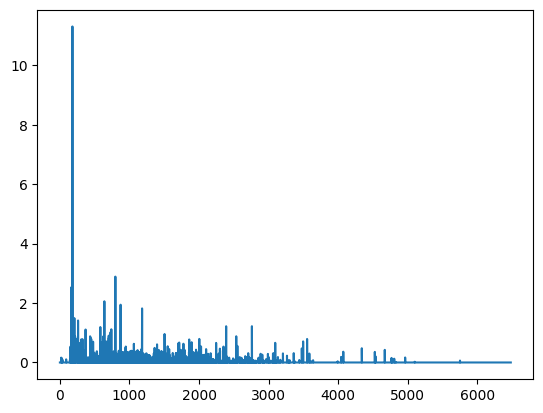

In [27]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

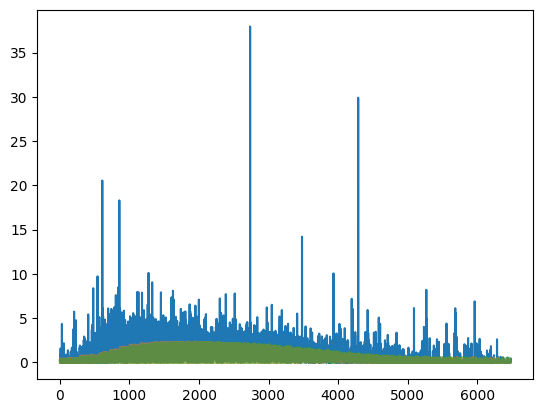

In [28]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    # if reducedata:
        # in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 12
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)

In [29]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
# plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

In [30]:
# t0 = time.time() outputs = net(x) torch.cuda.current_stream().synchronize() t1 = time.time()

decoder_time = []
for i in range(500):
    # start = time.process_time()
    start = time.time()
    output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
    torch.cuda.current_stream().synchronize()
    t1 = time.time()
    decoder_time.append(t1 - start)
    # decoder_time.append(time.process_time() - start)

In [31]:
print(np.mean(decoder_time), np.std(decoder_time))

0.048328779220581056 0.016064188276030327


Text(0, 0.5, 'decoder time (s)')

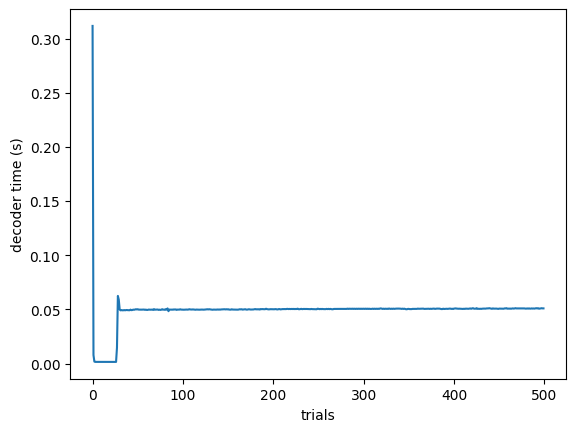

In [32]:
plt.plot(decoder_time)
plt.xlabel("trials")
plt.ylabel("decoder time (s)")

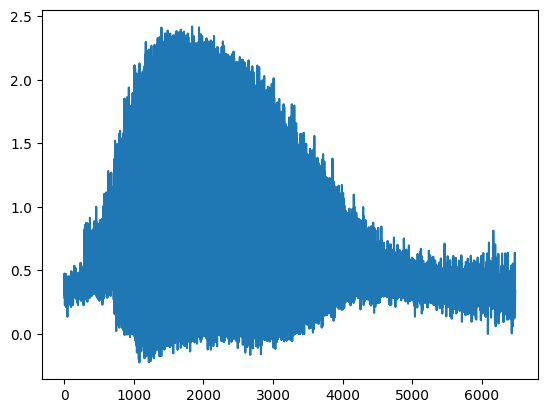

In [33]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
# post_samples = torch.cat(post_samples,1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


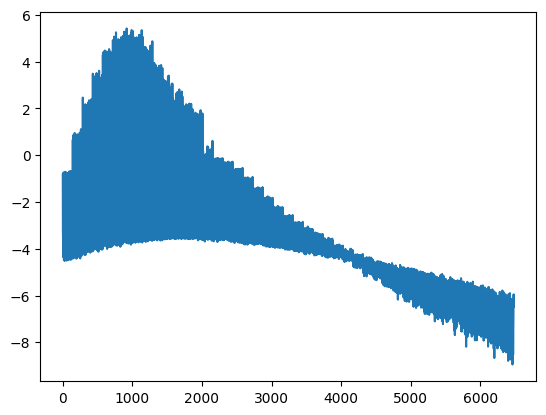

In [34]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [35]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

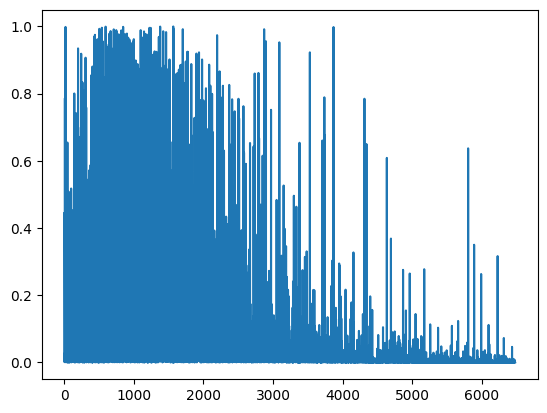

In [36]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [37]:
weight_dict = engine.model.prior.weight_dict

In [38]:
(weight_dict['01']==0).sum()

tensor(259269, device='cuda:6')

In [39]:
# engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu()
idx=5
# plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(23,16))
plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(41,13))

ValueError: cannot reshape array of size 6480 into shape (41,13)

In [39]:
# fwd_output.output_activations.shape

In [40]:
(output_hits.sum(dim=0) == 0).sum()
engine._config.model.output_smoothing_fct

# engine.model._energy_activation_fct
beta = torch.tensor(engine._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
output = engine.model._energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, False)
o1 = engine.model._energy_activation_fct(output_activations)
o2 = engine.model._hit_smoothing_dist_mod(output_hits, beta, False)

In [41]:
(output.sum(dim=0) == 0).sum()
(o1.sum(dim=0) == 0).sum()
# (o2.sum(dim=0) == 0).sum()
# (in_data.sum(dim=0) == 0).sum()
# in_data.shape
# engine.model._energy_activation_fct

tensor(0, device='cuda:6')

In [43]:
directory_path = f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
    print(modelname)
else:
    pass

lucky-voice-33


In [44]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=256, beta_init=4.0, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)

TypeError: find_beta() got an unexpected keyword argument 'num_reads'

In [45]:
engine.model._qpu_sampler.properties["chip_id"]

'Advantage_system6.4'

In [46]:
plt.plot(beta_list, linewidth=2.5, color="b" )
plt.xlabel("Iterations")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
# engine.model.eval();
# (engine.model.prior._weight_dict['01'] == 0).sum(axis=1)

NameError: name 'beta_list' is not defined

In [47]:
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)


In [48]:
plt.hist(rbm_energy_list[-1] + Hoffset, density=True, color="b")
plt.hist(dwave_energies_list[-1] + Hoffset, density=True, fc=(1, 0, 1, 0.5))
plt.xlabel("Ising Energy")
plt.ylabel("PDF")
plt.legend(["RBM", "QPU"])
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/Ising_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(len(rbm_energy_list[-1]))

NameError: name 'rbm_energy_list' is not defined

In [49]:
from utils.hists.RBMenergyHist import generate_rbm_energy_hist

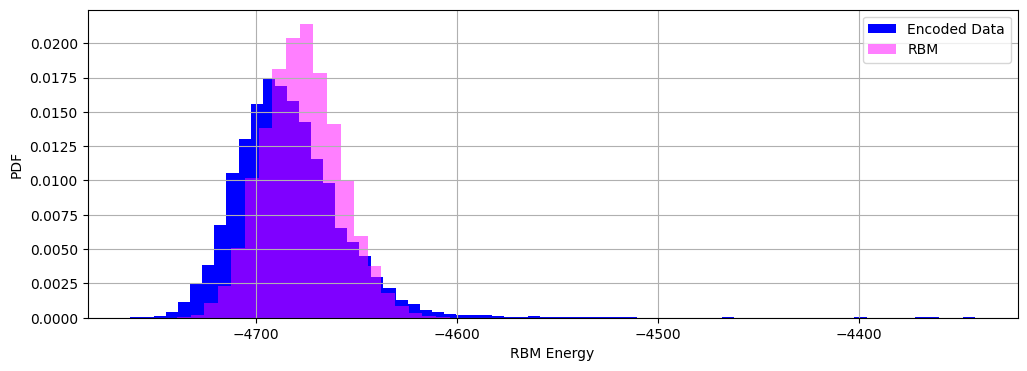

In [50]:
generate_rbm_energy_hist(engine, config.model, val_loader, False)

In [41]:
# Encoded data and RBM
encoded_data.shape

torch.Size([10000, 2048])

In [42]:
partition_size=config.model.n_latent_nodes
energy_encoded_data = []

engine.model.eval()
with torch.no_grad():
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        energy_encoded_data.append(post_samples_energy.detach().cpu())

energy_encoded_data = torch.cat(energy_encoded_data, dim=0)

In [19]:

partition_size=config.model.n_latent_nodes
encoded_data = []
energy_encoded_data = []

encoded_data_rdm = []
energy_encoded_data_rdm = []
engine.model.eval()
engine_2.model.eval()
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data.append(post_samples.detach().cpu())
        energy_encoded_data.append(post_samples_energy.detach().cpu())
        
        #Rdm model
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine_2.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine_2.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data_rdm.append(post_samples.detach().cpu())
        energy_encoded_data_rdm.append(post_samples_energy.detach().cpu())

encoded_data = torch.cat(encoded_data, dim=0)
energy_encoded_data = torch.cat(energy_encoded_data, dim=0)
        
encoded_data_rdm = torch.cat(encoded_data_rdm, dim=0)
energy_encoded_data_rdm = torch.cat(energy_encoded_data_rdm, dim=0)

p1,p2,p3,p4 = post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], \
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size]

energy_rbm_data = []
energy_rbm_rdm_data = []
with torch.no_grad():
    for i in range(10):
        # if i == 0:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0, p1, p2, p3, p4)
        p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling()
        rbm_samples_energy = engine.model.stater.energy_samples(p1, p2, p3, p4, 1.0)
        energy_rbm_data.append(rbm_samples_energy.detach().cpu())
        
        if i == 0:
            p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0)
        else:
            p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0, p1_r, p2_r, p3_r, p4_r)
        rbm_rdm_samples_energy = engine_2.model.stater.energy_samples(p1_r, p2_r, p3_r, p4_r, 1.0)
        energy_rbm_rdm_data.append(rbm_rdm_samples_energy.detach().cpu())
    
energy_rbm_data = torch.cat(energy_rbm_data, dim=0)
energy_rbm_rdm_data = torch.cat(energy_rbm_rdm_data, dim=0)

In [26]:
print("LL of trained model", -energy_encoded_data.mean() - lnZais)
print("LL of trained model. Gibbs samples data", -energy_rbm_data.mean() - lnZais)
print("LL of rdm model", -energy_encoded_data_rdm.mean() - lnZrais_rdm)
print("LL of rdm model. Gibbs Samples data", -energy_rbm_rdm_data.mean() - lnZrais_rdm)
print(lnZais, lnZais_rdm)

LL of trained model tensor(455.0283)
LL of trained model. Gibbs samples data tensor(435.9316)
LL of rdm model tensor(-2759.9045)
LL of rdm model. Gibbs Samples data tensor(-688.9333)
3788.4716796875 2720.4091796875


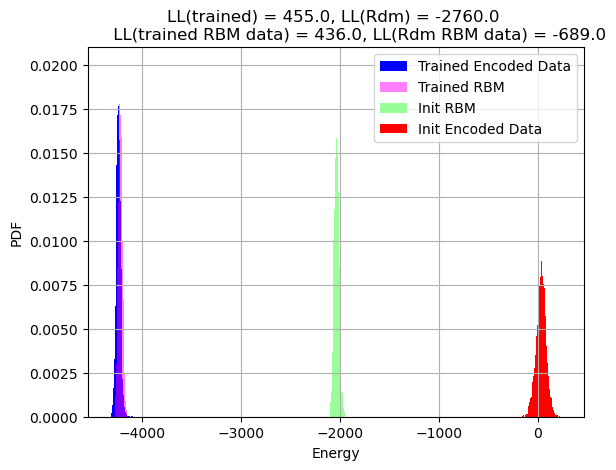

In [27]:
plt.hist(energy_encoded_data.numpy(), bins=70, linewidth=2.5, color="b", density=True)
plt.hist(energy_rbm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(1, 0, 1, 0.5))
plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))
plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend(["Trained Encoded Data", "Trained RBM", "Init RBM", "Init Encoded Data"])
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - lnZais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - lnZrais_rdm)} \n \
        LL(trained RBM data) = {np.round(-energy_rbm_data.mean() - lnZais)}, LL(Rdm RBM data) = {np.round(-energy_rbm_rdm_data.mean() - lnZrais_rdm)}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

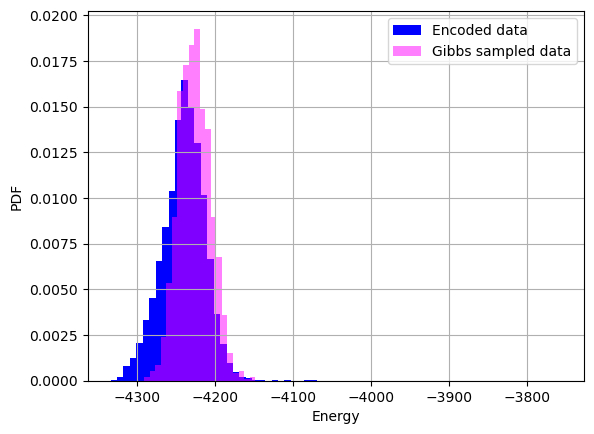

In [20]:
plt.hist(energy_encoded_data.numpy(), bins=70, linewidth=2.5, color="b", density=True)
plt.hist(energy_rbm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(1, 0, 1, 0.5))
# plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))
# plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend(["Encoded data", "Gibbs sampled data", "Init RBM", "Init Encoded Data"])
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
# plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - lnZais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - lnZrais_rdm)} \n \
        # LL(trained RBM data) = {np.round(-energy_rbm_data.mean() - lnZais)}, LL(Rdm RBM data) = {np.round(-energy_rbm_rdm_data.mean() - lnZrais_rdm)}')
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [210]:
# Sparsity and Energy

In [59]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        print(in_data.shape)
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000

        # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    #     if engine._config.engine.cl_lambda:
    #         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    #         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )

    #         en_labels.append(true_energy.detach().cpu())

        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
# xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()


torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128, 6480])
torch.Size([128,

In [60]:
(xgen_samples.sum(dim=0) == 0).sum()
(xrecon_samples.sum(dim=0) == 0).sum()
# (xtarget_samples.sum(dim=0) == 0).sum()
# print((xgen_samples.sum(dim=0) == 0).nonzero(as_tuple=True))
# print((xrecon_samples.sum(dim=0) == 0).nonzero(as_tuple=True))

tensor(206)

In [48]:
# 0.196888*9 + 0.154475
# 1.926467*100/60
# for xx in val_loader:
# for i,xx in enumerate(train_loader):
#     in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
#     print(i,in_data.shape)
# 0.061171*625
# 38.231875*100/60

63.719791666666666

In [52]:
print("mean qpu time", np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_qpu[i][0] for i in range(9)]))
print("mean gpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_gpu[i][0] for i in range(9)]))
print("mean gpu time/mean qpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)])/np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]))


IndexError: list index out of range

In [53]:
xgen_samples2 = []
with torch.no_grad():
    for xx in train_loader:
        if reducedata:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        else:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = sample_data.detach().cpu()*1000

        xgen_samples2.append( sample_data.detach().cpu())

xgen_samples2 = torch.cat(xgen_samples2, dim=0)

KeyboardInterrupt: 

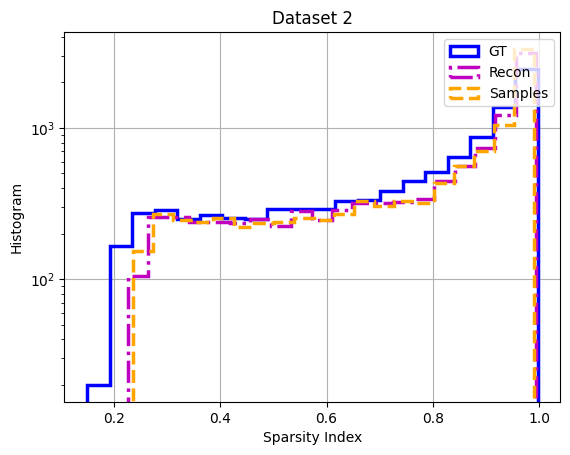

In [61]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

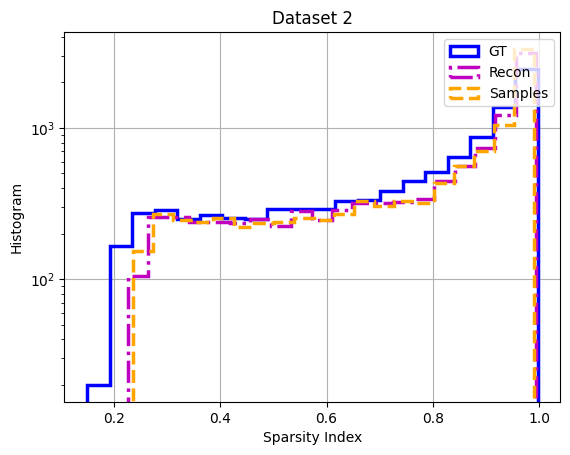

In [63]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/sparsity_RDM_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [36]:
# idxPrev = 0
# # for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(1,5)]):
# # for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.xlabel("Sparsity Index")
#     plt.ylabel("Histogram")
#     plt.legend(["GT", "Recon", "Sample"])
#     plt.title(f'{part} Layer {i}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

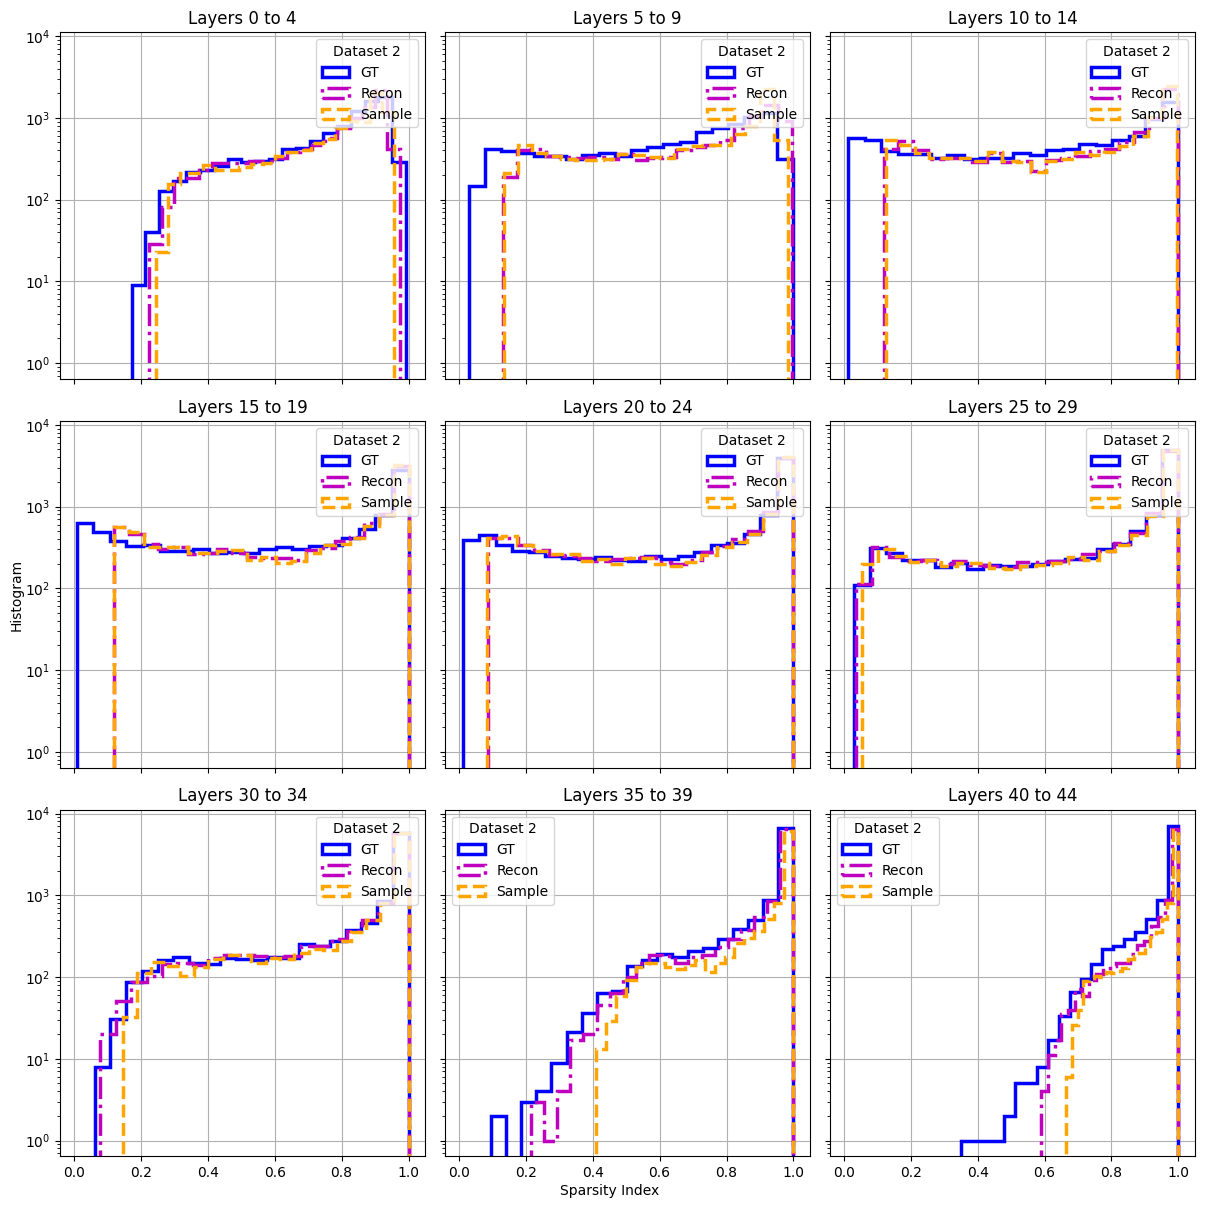

In [65]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, 0.0, 'Sparsity Index', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [50]:
(20+136+21)*784/1000

138.768

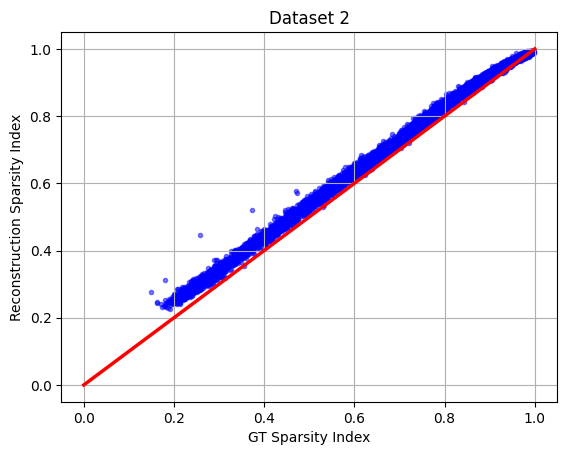

In [67]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="b")
plt.plot([0,1],[0,1], c='red', lw=2.5)
plt.xlabel('GT Sparsity Index')
plt.ylabel('Reconstruction Sparsity Index')
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [68]:
xgen_samples2.shape

AttributeError: 'list' object has no attribute 'shape'

In [69]:
E_right = 10000
E_left = 4000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
len(idxEnFilter)

1332

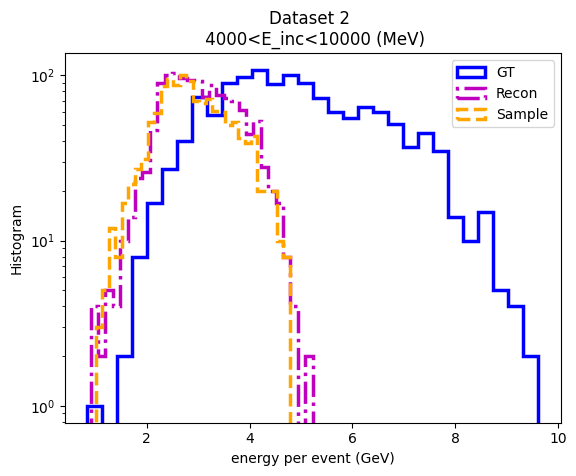

In [70]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")

plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]} \n {E_left}<E_inc<{E_right} (MeV)')
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

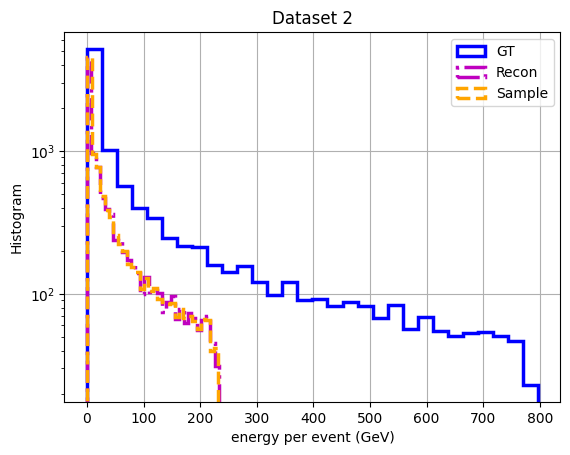

torch.Size([10000, 6480])


In [73]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
#plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="green", linestyle="dashed")
#plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
#plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
#plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

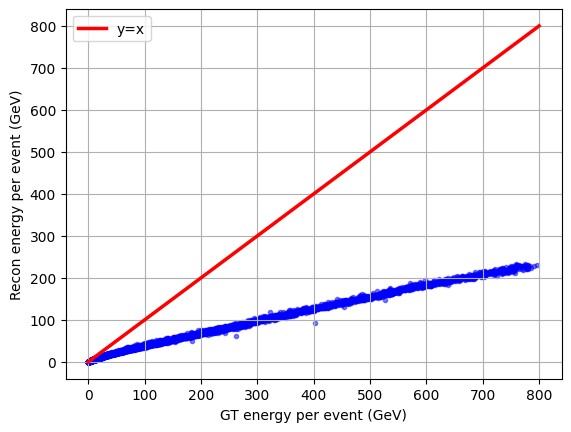

In [75]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
plt.plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
plt.legend()
plt.grid("True")
plt.xlabel("GT energy per event (GeV)")
plt.ylabel("Recon energy per event (GeV)")
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

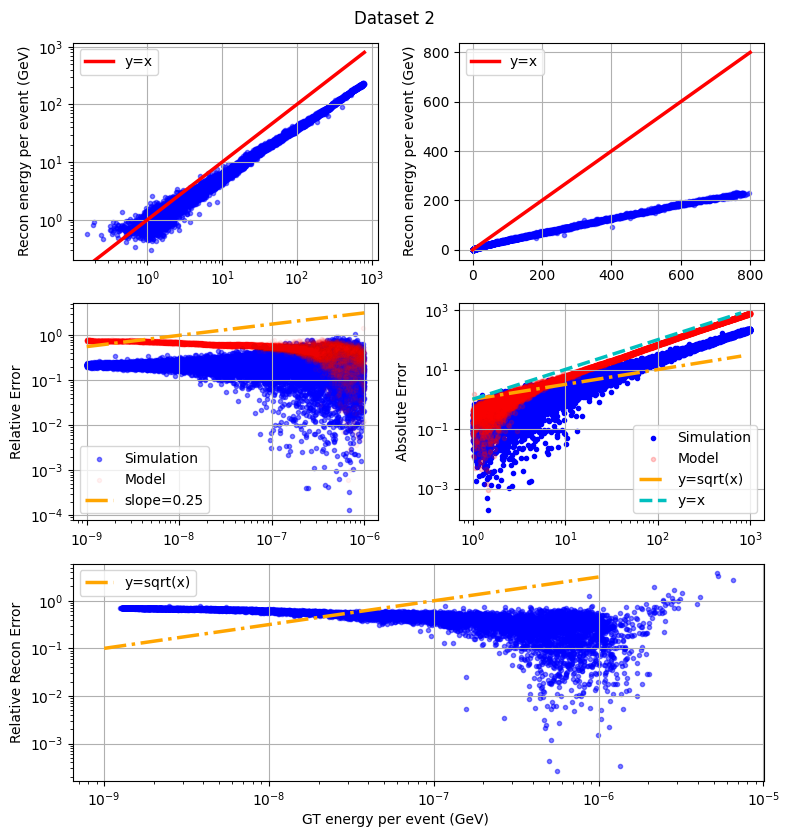

In [77]:
fig, axes = plt.subplots(3,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,0].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,1].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,1].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
axes[0,1].set_ylabel("Recon energy per event (GeV)")
axes[0,1].legend()
axes[0,1].grid("True")

# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].scatter(1/entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(1/entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].plot([1e-9,1e-6],np.power([1e-9,1e-6],0.25)*np.power(10,2.0), c='orange', lw=2.5, label='slope=0.25', linestyle="dashdot")
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

# axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
# axes[1,1].set_title(f'{ds[part]}')
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()


# Merge the first row's axes
gs = axes[2, 0].get_gridspec()
for ax in axes[2, :]:
    ax.remove()
ax_big = fig.add_subplot(gs[2, :])
ax_big.scatter(1/xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].set_title(f'{ds[part]}')
ax_big.plot([1e-9,1e-6],np.sqrt([1e-9,1e-6])*np.power(10,3.5), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
# axes[1,1].plot([1e-9,1e-6],np.linspace(1e-9,1e-6)*np.power(10,3.5), c='c', lw=2.5, label='y=x', linestyle="dashed")
ax_big.grid("True")
ax_big.set_yscale('log')
ax_big.set_xscale('log')
ax_big.legend()
ax_big.set_ylabel("Relative Recon Error")
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [1]:
fig, axes = plt.subplots(3,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,0].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/1000, marker='.', alpha=.5, color="b")
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
axes[0,1].set_ylabel("Abs error (GeV)")
#axes[0,1].set_ylim([-40,40])
# axes[0,1].legend()
# axes[0,1].set_yscale('log')
axes[0,1].grid("True")

# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].plot([1e-3,1e0],np.power([1e-3,1e0],0.25)*np.power(10,2.0), c='orange', lw=2.5, label='slope=0.25', linestyle="dashdot")
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

# axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
# axes[1,1].set_title(f'{ds[part]}')
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()


# Merge the first row's axes
gs = axes[2, 0].get_gridspec()
for ax in axes[2, :]:
    ax.remove()
ax_big = fig.add_subplot(gs[2, :])
ax_big.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
# axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].set_title(f'{ds[part]}')
ax_big.plot([1e-3,1e1],np.sqrt([1e-3,1e1])*np.power(1,3.5), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
# axes[1,1].plot([1e-9,1e-6],np.linspace(1e-9,1e-6)*np.power(10,3.5), c='c', lw=2.5, label='y=x', linestyle="dashed")
ax_big.grid("True")
ax_big.set_yscale('log')
ax_big.set_xscale('log')
ax_big.legend()
ax_big.set_ylim([1e-5,1e1])
ax_big.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax_big.set_ylabel("Relative Recon Error")
plt.savefig(f'/home/dsogutlu/temp/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

NameError: name 'plt' is not defined

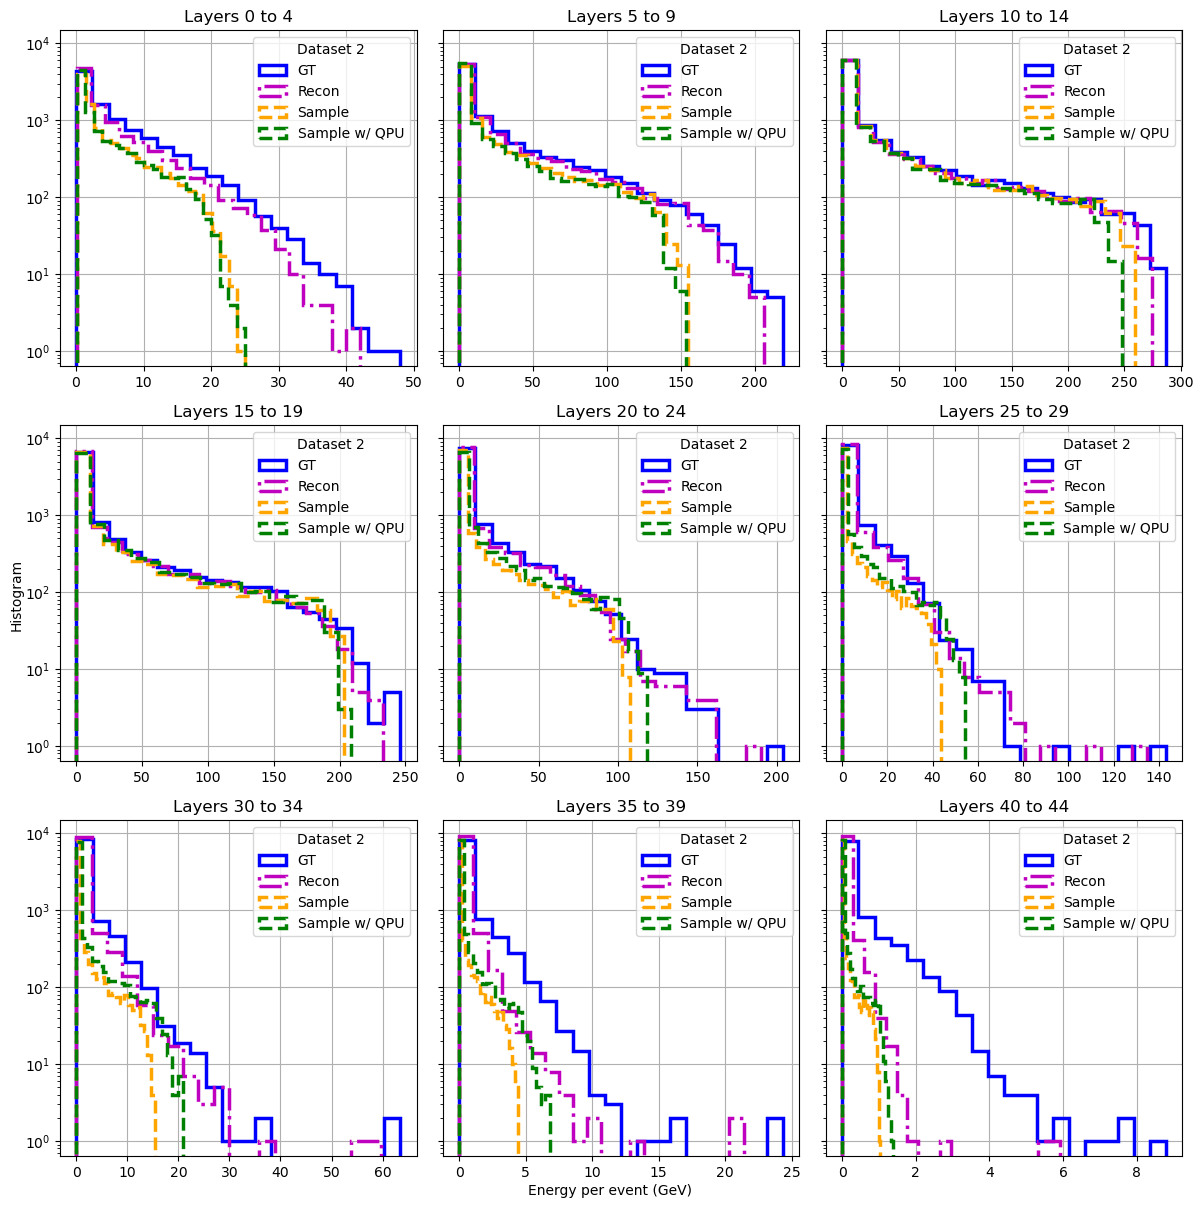

In [34]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


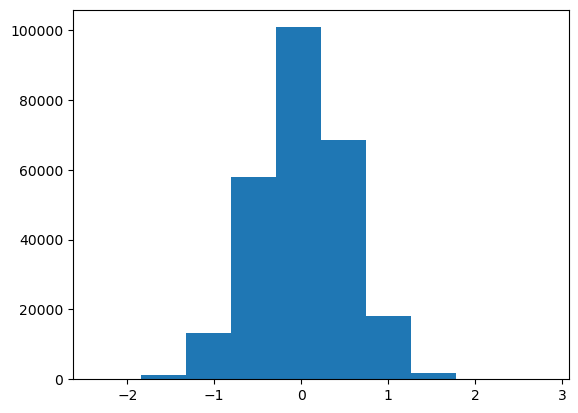

In [42]:
# plt.hist(engine._model.prior._weight_dict['23'].reshape(-1).detach().cpu().numpy())
# plt.show()
# engine._model.prior._weight_dict['01'].reshape(-1)

In [105]:
# entarget_samples.max()
# ll = len([1,2,5,10,20,50,100,200,500,1000,2000,5000])
# gen_bs = true_energy.shape[0]

In [156]:
xgen_samples2 = []
en_input = [1,2,3,5,10,20,30,50,100,200,300,500,1000,2000,3000,5000,10000,20000]
ll = len(en_input)
gen_bs = 2048 #true_energy.shape[0]
with torch.no_grad():
    for i in en_input:
        if reducedata:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            engine._model.sampler._batch_size = gen_bs # true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=1000*i, measure_time=True)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        else:
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = sample_data.detach().cpu()*1000

        xgen_samples2.append( sample_data.detach().cpu())

xgen_samples2 = torch.cat(xgen_samples2, dim=0)

In [186]:
energy_gen = xgen_samples2.sum(dim=1)
m_energy_gen = [energy_gen[i*gen_bs:gen_bs*(i+1)].sum().item()/1000 for i in range(ll)]
sd_energy_gen = [energy_gen[i*gen_bs:gen_bs*(i+1)].std().item()/1000 for i in range(ll)]
lin_inter = np.power(m_energy_gen,1/2) * (1 - np.array(m_energy_gen)/np.array(m_energy_gen).max()) \
    + np.power(m_energy_gen,1) * np.array(m_energy_gen)/np.array(m_energy_gen).max()


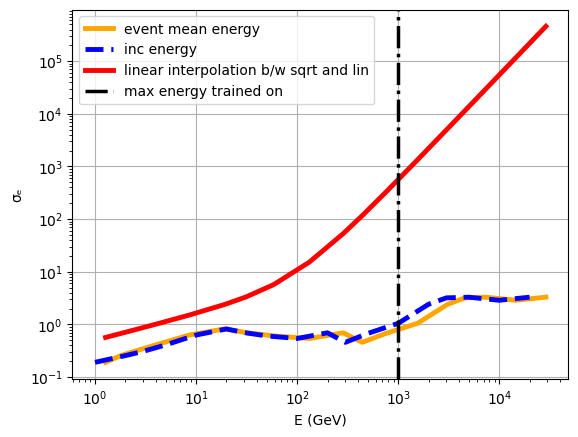

In [189]:
plt.plot(np.array(m_energy_gen)/1000, sd_energy_gen, c='orange', lw=3.5, label='event mean energy')
plt.plot((np.array(en_input)), sd_energy_gen, c='blue', lw=3.5, label='inc energy', linestyle="dashed")
plt.grid("True")
# plt.plot([1,10], np.sqrt([1,10])*np.power(10, -0.8))
plt.plot(np.array(m_energy_gen)/1000, lin_inter*np.power(10, -1.8), c='red', lw=3.5, label='linear interpolation b/w sqrt and lin')
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=1000, c='black', lw=2.5, label='max energy trained on', linestyle="dashdot")
plt.legend()
plt.xlabel("E (GeV)")
plt.ylabel("σₑ")
plt.show()

In [190]:
# plt.plot(np.array(m_energy_gen), np.array(sd_energy_gen)/np.array(m_energy_gen))
# # plt.plot((np.array(en_input)*1000), sd_energy_gen)
# # plt.plot(np.array(m_energy_gen), np.sqrt(m_energy_gen)*np.power(10, -2.2))
# # plt.plot(np.array(m_energy_gen), np.sqrt(m_energy_gen)*np.power(10, 0.2))
# plt.yscale('log')
# plt.xscale('log')
# plt.axvline(x=1000000)
# plt.show()

# np.power(m_energy_gen,1/2) * (1 - np.array(m_energy_gen)/np.array(m_energy_gen).max()) + np.power(m_energy_gen,1) * np.array(m_energy_gen)/np.array(m_energy_gen).max()

In [151]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [41]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [42]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
else:
    in_data = in_data.detach().cpu()*1000
    recon_data = fwd_output.output_activations.detach().cpu()*1000
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = sample_data.detach().cpu()*1000

In [303]:
THRSH=7
recon_data = recon_data * (recon_data > THRSH)
sample_data = sample_data * (sample_data > THRSH)

In [44]:
# HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [57]:
HLF_1_electron.relevantLayers = [0,1,2]

In [43]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
(((in_data - recon_data)/(in_data+1e-5))**2).sum(dim=1).argsort()[-200:-1]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

tensor([ 951,  246,  369,   70,  957,  944,  614,  196,  330,  211,  515,  258,
         737,  787,  543,  394,   23,  791,  818,  643,  123,  644,   86,  690,
         314,  105,  428,  635,  771,   65,   81,  205,  528,  285,  788,   80,
         458,  893,  200,  502,  381,  518,  227,   12,  683,  332, 1007,  814,
         949,    2,  781,  175,  306,  395,  465,   95,  331,  261,  891,   84,
         453,  499,  257,  803,  964,  985,  565,  943,  580,  797,  928,  288,
         112,  896,  479,  111,  299,  321,  599,   63,   93,  419,  416, 1020,
         510,  763,  660,  924,  357,  626,  826,  482,    7,  795,  446,  228,
        1011,    3,  272,  849,  883,  552,  674,  932,  783,  136,  328, 1005,
         539,  551,  885,  619,  550,  811,  975,  911,  131,  231,  923,  406,
         254,  106,  141,  354,  506,  986,  216,   17,  918,  253,  962,  171,
         836,  520,  844,  500,  750,  485,  822,  688,   67,  805,  579,    4,
         617,   11,  984,  704,  754,  4

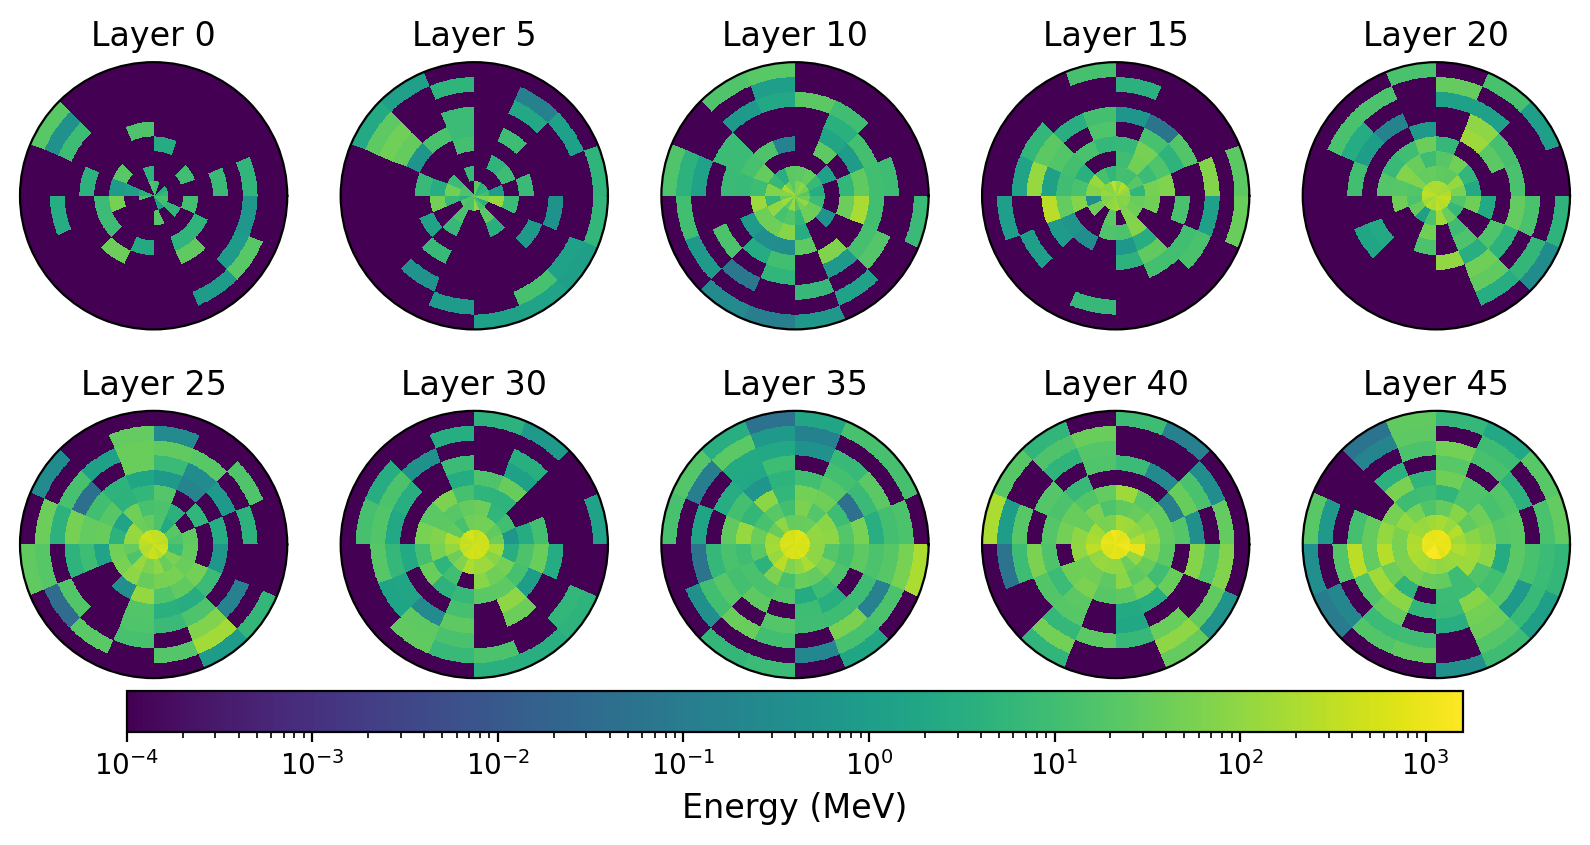

In [44]:
idx=951
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

# HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)


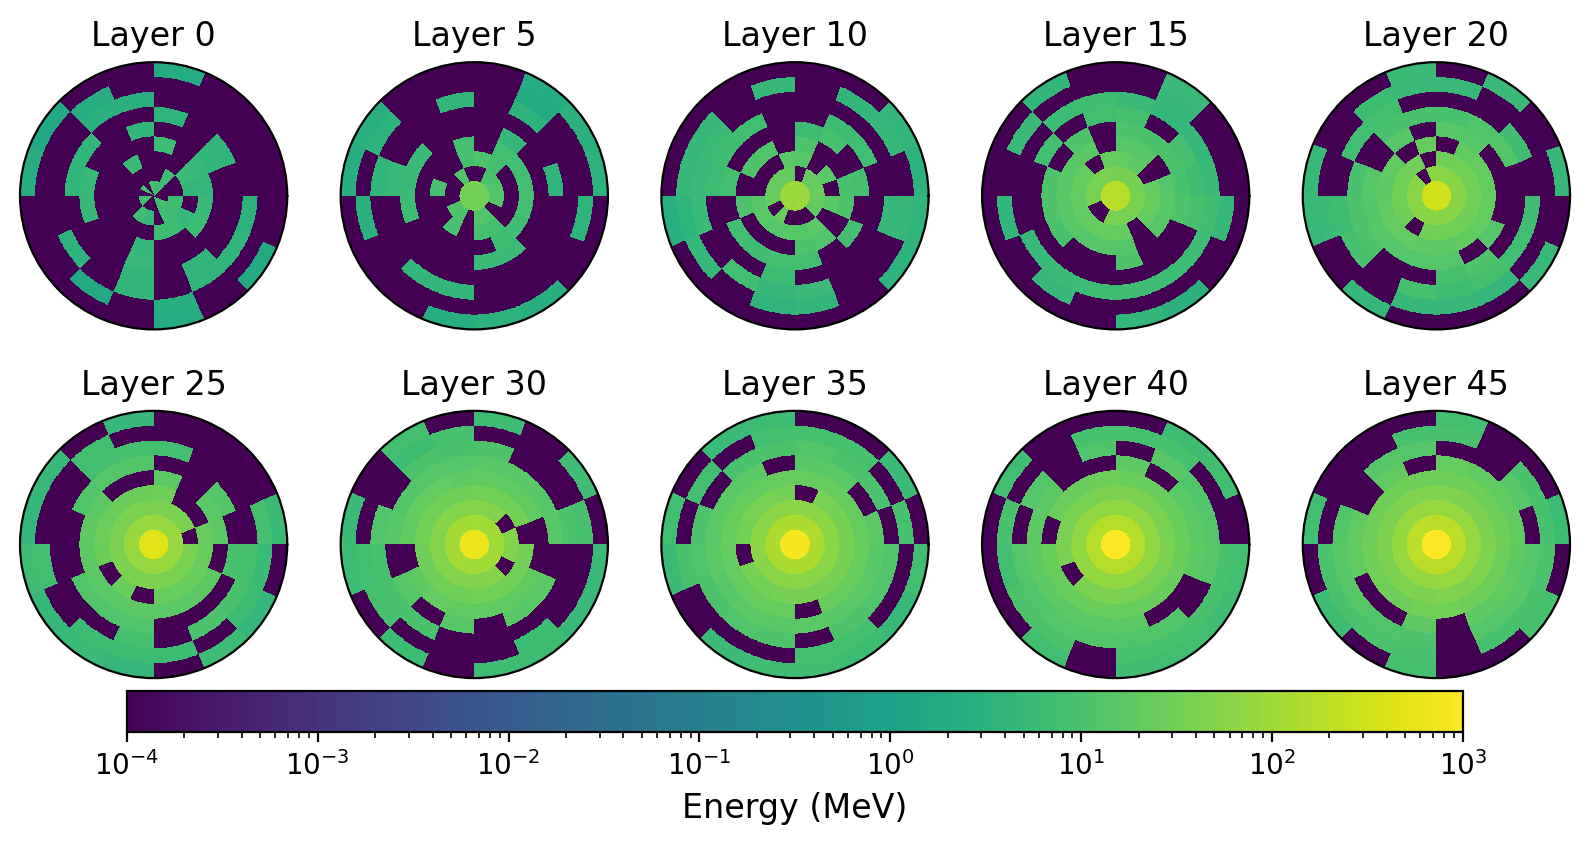

In [45]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

# HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)

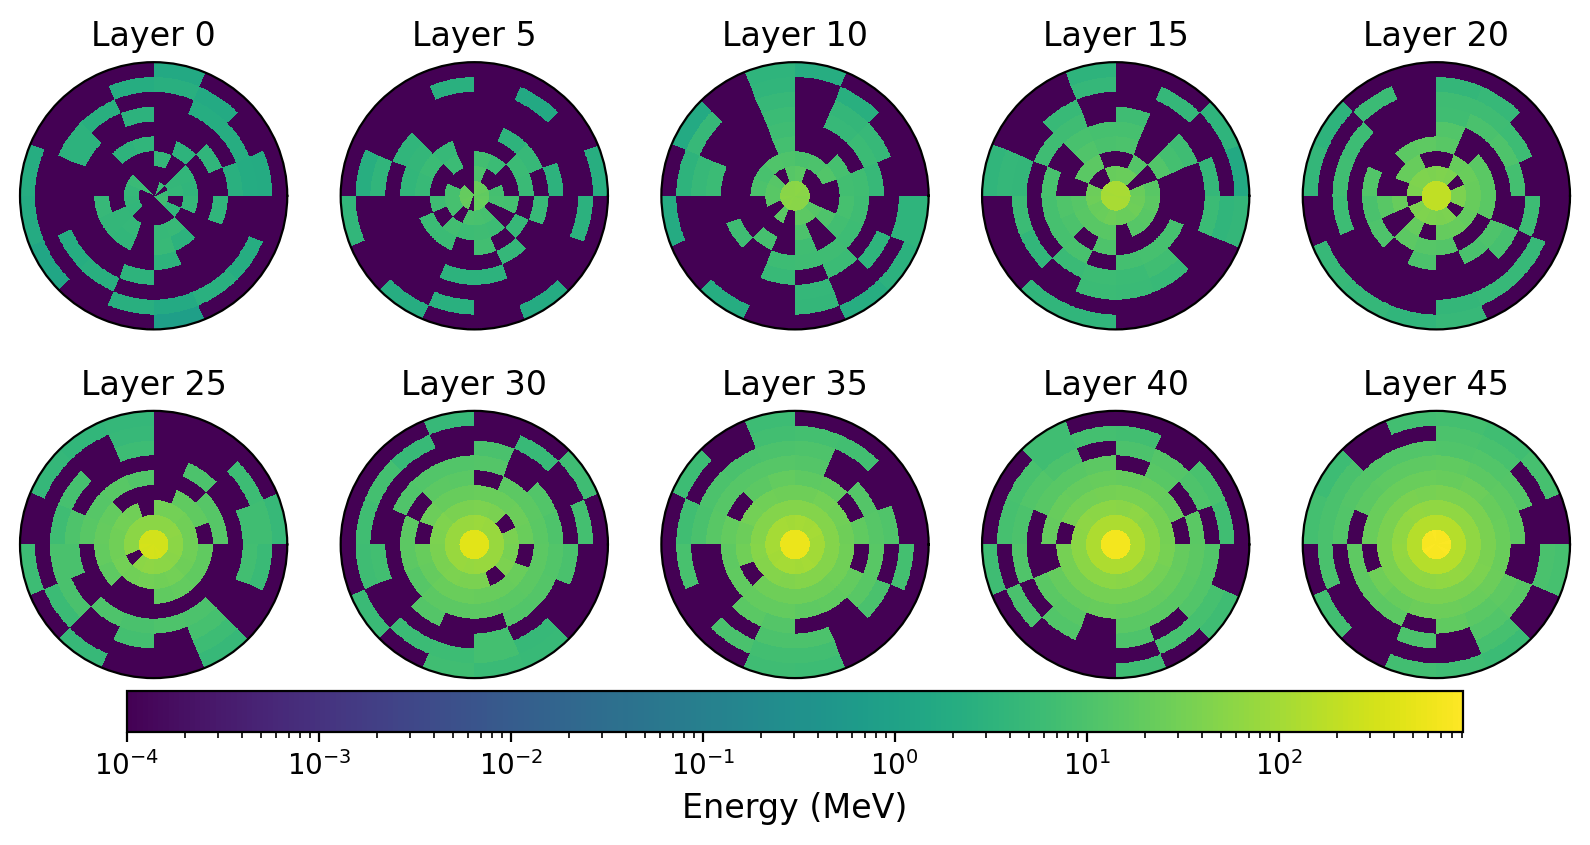

In [46]:
# HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

# HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)

In [103]:
# HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_QPU_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=None)

IndexError: index 6480 is out of bounds for dimension 0 with size 784

In [195]:
#Average Shower
# modelname
idx_list = torch.tensor(range(6480))

pos_z = idx_list // 144
# pos_z
pos_theta = (idx_list - 144*pos_z) // 9
pos_theta
pos_r = (idx_list - 144*pos_z) % 9
pos_r

tensor([0, 1, 2,  ..., 6, 7, 8])

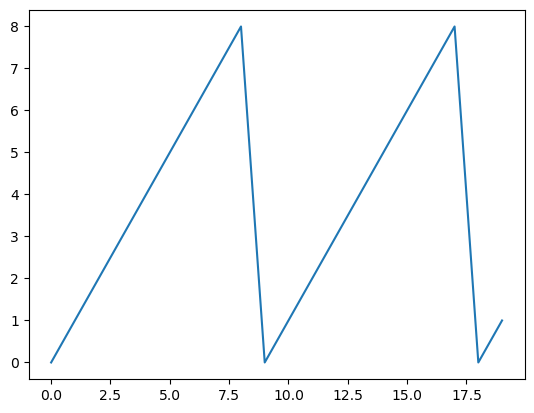

In [88]:
plt.plot(pos_r[:20].detach().numpy())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Let's define the positional_encoding function as before
def positional_encoding(pos, d_model):
    """
    Computes the positional encoding for a given position and model dimension.
    Arguments:
    pos -- a scalar or a vector of positions
    d_model -- the dimensionality of the model
    Returns:
    pe -- the positional encoding for the given position(s)
    """
    pe = np.zeros((len(pos), d_model))
    for i in range(d_model):
        div_term = np.exp(i * -np.log(10000.0) / d_model)
        if i % 2 == 0:
            pe[:, i] = np.sin(pos * div_term)
        else:
            pe[:, i] = np.cos(pos * div_term)
    return pe

# Define the sentence and parameters
sentence = "the dog wags the tail more often during the night"
words = sentence.split()
num_words = len(words)
d_model = 512  # The dimensionality is often larger, such as 512

# Calculate the positional encoding for the number of words
positions = np.arange(num_words)
pe = positional_encoding(positions, d_model)

# For visualization, let's plot just the first two dimensions
plt.figure(figsize=(14, 8))
plt.plot(positions, pe[:, 0], 'o-', label='Dimension 1 (sin)')
plt.plot(positions, pe[:, 1], 'o-', label='Dimension 2 (cos)')
plt.xticks(positions, words, rotation=90)
plt.xlabel('Position')
plt.ylabel('Positional Encoding Value')
plt.title('Positional Encoding of Sentence')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
def positional_encoding(pos, d_model):
    """
    Computes the positional encoding for a given position and model dimension.
    Arguments:
    pos -- a scalar or a vector of positions
    d_model -- the dimensionality of the model
    Returns:
    pe -- the positional encoding for the given position(s)
    """
    pe = torch.zeros((len(pos), d_model))
    for i in range(d_model):
        div_term = torch.exp(i * -torch.log(torch.tensor([10000.0])) / d_model)
        if i % 2 == 0:
            pe[:, i] = torch.sin(pos * div_term)
        else:
            pe[:, i] = torch.cos(pos * div_term)
    return pe.detach().sum(dim=1)

In [104]:
def _cylinder_pos_enc(lz=512,ltheta=512, lr=512):
    PE_z = positional_encoding(torch.tensor(range(45)),lz).repeat_interleave(144)
    PE_theta = positional_encoding(torch.tensor(range(16)),ltheta).repeat_interleave(9).repeat(45)
    PE_r = positional_encoding(torch.tensor(range(9)),lr).repeat(16*45)
    
    return PE_z + PE_theta + PE_r, PE_z, PE_theta , PE_r

In [94]:
PE_z = positional_encoding(torch.tensor(range(16)),128)
PE_z

tensor([64.0000, 69.3392, 69.7215, 66.0675, 61.1625, 57.7595, 56.8805, 57.5240,
        57.8537, 56.7987, 54.7786, 53.0912, 52.6394, 53.1565, 53.5532, 52.9760])

In [95]:
# plt.plot(PE_z.numpy())
# plt.plot(PE[:,1].detach().numpy())
# PE_z.repeat_interleave(45)
if 1 == True:
    print(1)

1


In [96]:
# positional_encoding(torch.tensor(range(16)),128).repeat_interleave(9).repeat(45)[:145]
# positional_encoding(torch.tensor(range(45)),128).repeat_interleave(144)
# positional_encoding(torch.tensor(range(9)),128).repeat(16*45)

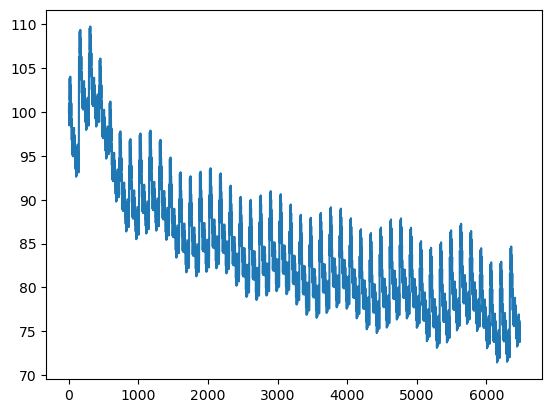

In [112]:
cyl_enc, PE_z, PE_theta , PE_r = _cylinder_pos_enc(lz=128, ltheta=64, lr=9)
plt.plot(cyl_enc.numpy())

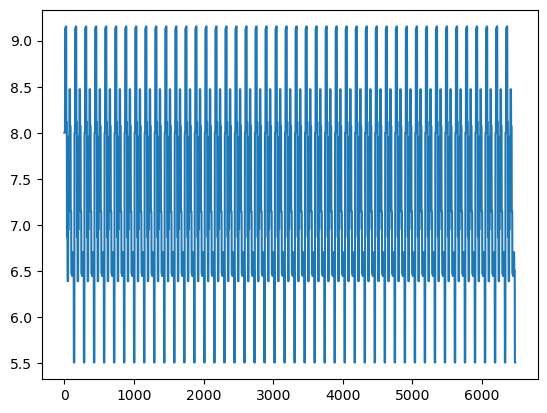

In [110]:
plt.plot(PE_theta.numpy()[:-1])

In [175]:
(in_data + cyl_enc)

tensor([[194.8870, 194.8976, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        [217.4611, 194.8976, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        [192.0000, 203.3723, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        ...,
        [192.0000, 194.8976, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        [197.3728, 202.7562, 195.0907,  ..., 172.9958, 173.6140, 173.7842],
        [192.0000, 194.8976, 195.0907,  ..., 172.9958, 173.6140, 173.7842]])

In [119]:

# cyl_enc.to(in_data.device)
in_data.to('cuda')

tensor([[ 0.0000,  6.9262,  1.3491,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.5212,  4.6352,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.6255, 33.7257, 21.9538,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.8941,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.4203,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

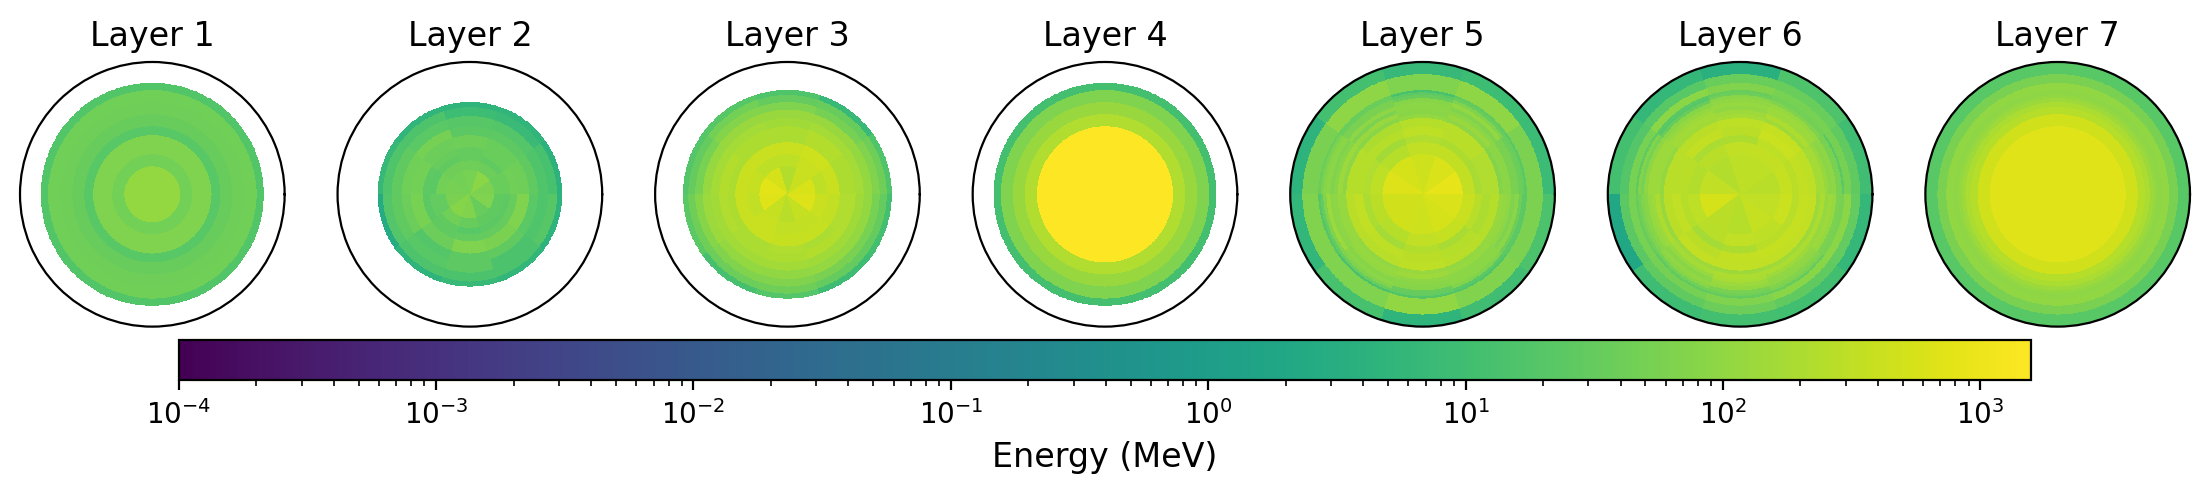

In [636]:
HLF_1_pions.DrawAverageShower(in_data[idx:idx+100,:].detach().cpu().numpy(), filename=None)

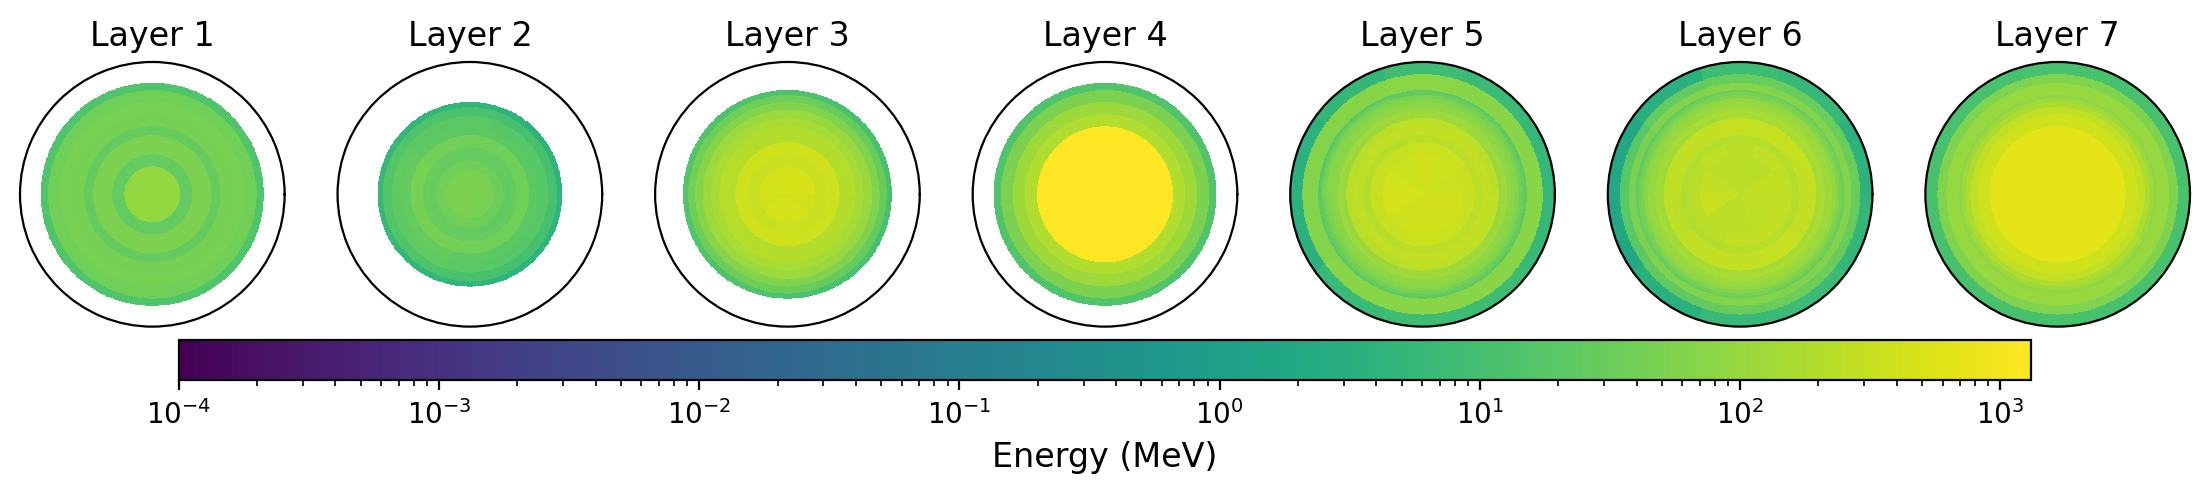

In [637]:
HLF_1_pions.DrawAverageShower(recon_data[idx:idx+100,:].detach().cpu().numpy(), filename=None)

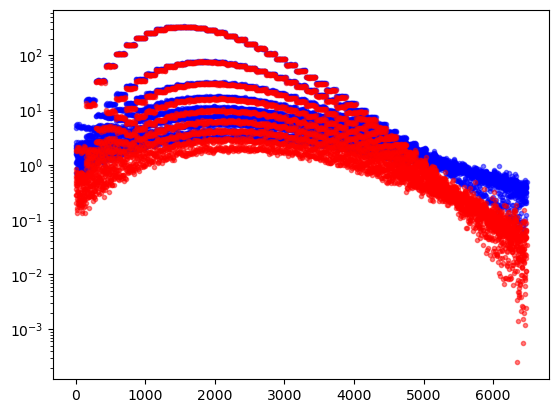

In [104]:
plt.plot(xtarget_samples.mean(dim=0).numpy(), marker='.', alpha=.5, color="b", linewidth=0)
plt.plot(xrecon_samples.mean(dim=0).numpy(), marker='.', alpha=.5, color="r", linewidth=0)
plt.yscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# LL

In [83]:
ww = load_RBM_state("/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_1_9_weights.pth", dev)

[18:37:33.760] INFO   __main__                                          Loading RBM state


In [263]:
dte = '16-33-07' #compound sponge?
# 17-38-46 zany cloud
# dte = '17-38-46'
lnZais_list = []
lnZrais_list = []
en_encoded_list = []
for i in range(1,100,10):
    print(i)
    engine_2.model.sampler._prbm._weight_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/RBM_{i}_9_weights.pth', dev)
    engine_2.model.sampler._prbm._bias_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/RBM_{i}_9_biases.pth', dev)
    en = -torch.load(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/RBM_{i}_9_EncEn.pth').mean()
    lnZais_list.append(engine_2.model.stater.AIS(30).detach().cpu().item())
    lnZrais_list.append(engine_2.model.stater.RAIS(30).detach().cpu().item())
    en_encoded_list.append(en)
    

[22:03:44.972] INFO   __main__                                          Loading RBM state
[22:03:44.976] INFO   __main__                                          Loading RBM state


1


[22:05:58.202] INFO   __main__                                          Loading RBM state
[22:05:58.207] INFO   __main__                                          Loading RBM state


11


[22:08:12.260] INFO   __main__                                          Loading RBM state
[22:08:12.264] INFO   __main__                                          Loading RBM state


21


[22:10:25.017] INFO   __main__                                          Loading RBM state
[22:10:25.021] INFO   __main__                                          Loading RBM state


31


[22:12:37.836] INFO   __main__                                          Loading RBM state
[22:12:37.841] INFO   __main__                                          Loading RBM state


41


[22:14:50.133] INFO   __main__                                          Loading RBM state
[22:14:50.139] INFO   __main__                                          Loading RBM state


51


[22:17:02.639] INFO   __main__                                          Loading RBM state
[22:17:02.644] INFO   __main__                                          Loading RBM state


61


[22:19:14.921] INFO   __main__                                          Loading RBM state
[22:19:14.926] INFO   __main__                                          Loading RBM state


71


[22:21:26.752] INFO   __main__                                          Loading RBM state
[22:21:26.756] INFO   __main__                                          Loading RBM state


81


[22:23:40.183] INFO   __main__                                          Loading RBM state
[22:23:40.187] INFO   __main__                                          Loading RBM state


91


In [265]:
import pandas as pd
# entropy_model_data = pd.read_csv(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/entropy_zano.csv');
# pos_model_data = pd.read_csv(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/pos_zano.csv');
# neg_model_data = pd.read_csv(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/neg_zano.csv');

entropy_model_data = pd.read_csv(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/entropy.csv');
pos_model_data = pd.read_csv(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/pos.csv');
neg_model_data = pd.read_csv(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-27/{dte}/wandb/latest-run/files/RBM/neg.csv');

entropy = np.array(entropy_model_data.iloc[:,1])
pos = np.array(pos_model_data.iloc[:,1])
neg = np.array(neg_model_data.iloc[:,1])

entropy_plus_pos = np.array(entropy) + np.array(pos)

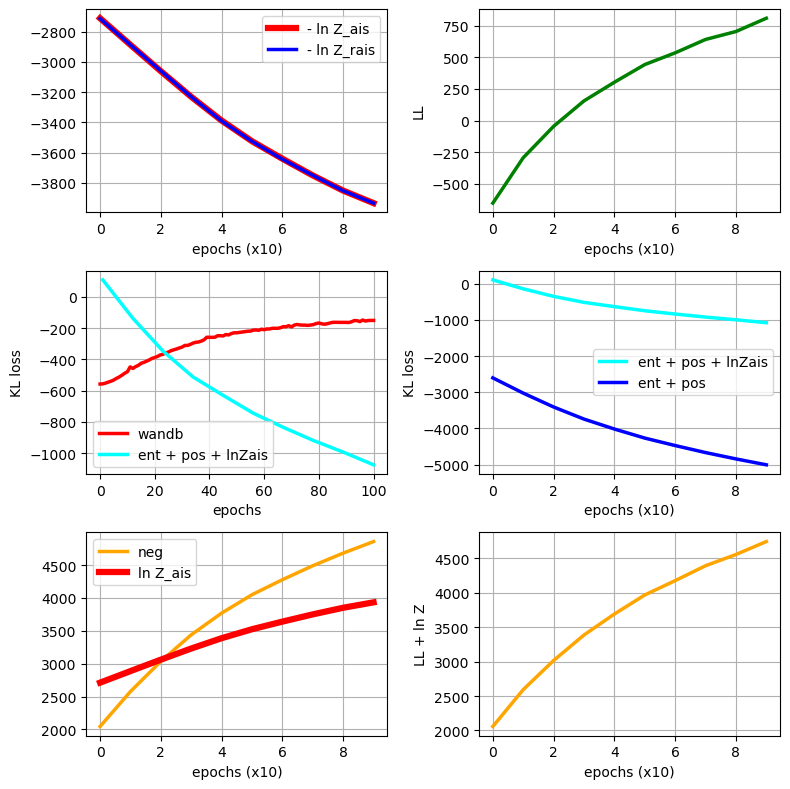

In [266]:
fig, axes = plt.subplots(3,2, figsize=(8,8), tight_layout=True)

axes[0,0].plot(-np.array(lnZais_list), c='red', lw=4.5, label='- ln Z_ais')
axes[0,0].plot(-np.array(lnZrais_list), c='blue', lw=2.5, label='- ln Z_rais')
axes[0,0].set_xlabel("epochs (x10)")
axes[0,0].legend()
axes[0,0].grid("True")

axes[0,1].plot(np.array(en_encoded_list) - np.array(lnZais_list), c='green', lw=2.5)
axes[0,1].set_ylabel("LL")
axes[0,1].set_xlabel("epochs (x10)")
axes[0,1].grid("True")

axes[1,0].plot(range(101), (entropy + pos + neg), c='red', lw=2.5, label="wandb")
axes[1,0].plot(range(1,101,11), (entropy + pos)[0:-1:11] + np.array(lnZais_list), c='cyan', lw=2.5, label="ent + pos + lnZais")
axes[1,0].grid("True")
axes[1,0].legend()
axes[1,0].set_ylabel("KL loss")
axes[1,0].set_xlabel("epochs")

axes[1,1].plot((entropy + pos)[0:-1:11] + np.array(lnZais_list), c='cyan', lw=2.5, label="ent + pos + lnZais")
axes[1,1].plot((entropy + pos)[0:-1:11], c='blue', lw=2.5, label="ent + pos")
axes[1,1].grid("True")
axes[1,1].legend()
axes[1,1].set_ylabel("KL loss")
axes[1,1].set_xlabel("epochs (x10)")


axes[2,0].plot(neg[0:-1:11], c='orange', lw=2.5, label="neg")
axes[2,0].plot(np.array(lnZais_list), c='red', lw=4.5, label='ln Z_ais')
axes[2,0].grid("True")
# axes[2,0].set_ylabel("LL + ln Z")
axes[2,0].legend()
axes[2,0].set_xlabel("epochs (x10)")


axes[2,1].plot(np.array(en_encoded_list), c='orange', lw=2.5)
axes[2,1].grid("True")
axes[2,1].set_ylabel("LL + ln Z")
axes[2,1].set_xlabel("epochs (x10)")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [172]:
run = wandb.Api(api_key= "").run("jtoledo/caloqvae/n9y23yq6")
summary = run.summary
hist = run.history()
hist.head(20)
true_indices = [i for i, x in enumerate(np.isnan(hist["val_kl_loss"])) if x==False]

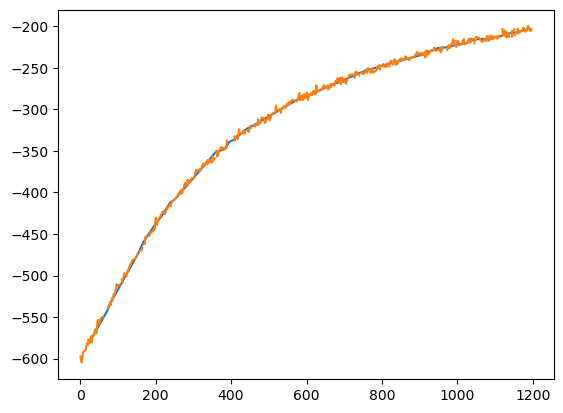

In [185]:
plt.plot(hist["_step"][true_indices], hist["val_kl_loss"][true_indices])
plt.plot(hist["_step"], hist["kl_loss"])

In [187]:
prelu_dict = {}
for i in range(4):
    for name, param in engine.model.encoder._networks[i][0].seq2[4].named_parameters():
        # print(name, param.data.detach().cpu().numpy())
        prelu_dict[i] = param.data.detach().cpu().numpy()

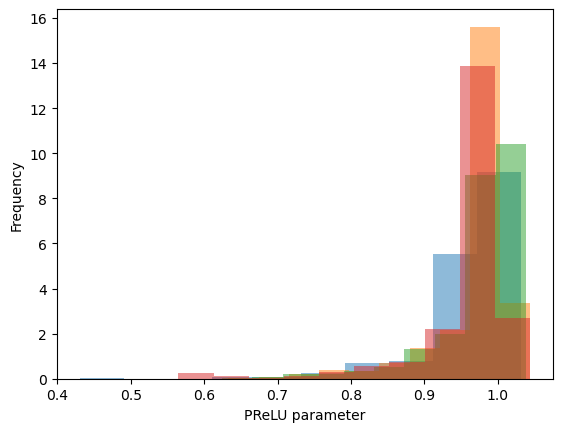

In [188]:
for i in range(4):
    plt.hist(prelu_dict[i], alpha=0.5, density=True)
plt.xlabel("PReLU parameter")
plt.ylabel("Frequency")
plt.show()

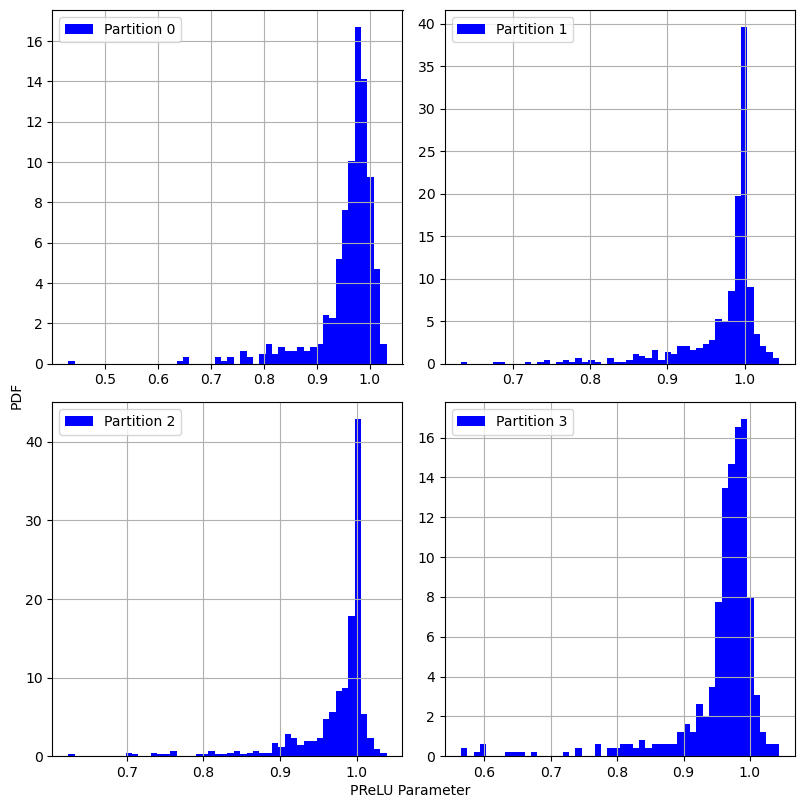

In [189]:
fig, axes = plt.subplots(2,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'PReLU Parameter', ha='center')
# fig.text(0.5, 1.0, f'PDF', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'PDF', va='center', rotation='vertical')

axes[0,0].hist(prelu_dict[0], bins=50, density=True, color="b")
axes[0,0].legend(["Partition 0"])
axes[0,0].grid("True")

axes[0,1].hist(prelu_dict[1], bins=50, color="b", density=True)
axes[0,1].legend(["Partition 1"])
axes[0,1].grid("True")

axes[1,0].hist(prelu_dict[2], bins=50, color="b", density=True)
axes[1,0].legend(["Partition 2"])
axes[1,0].grid("True")

axes[1,1].hist(prelu_dict[3], bins=50, color="b", density=True)
axes[1,1].legend(["Partition 3"])
axes[1,1].grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/PReLU_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [105]:
####

In [156]:

τₛ = 0.020+0.136+0.021
τₚ = 15.92


temp_steps=5
training_size = 80000
val_size = 10000
val_bs = 1024
train_bs = 128

train_b_num = np.ceil(training_size/train_bs) # assuming batchsize 128
val_b_num = np.ceil(val_size/val_bs) # assuming batchsize 1024
temp_opt_samp_size = 256
train_time_per_epoch = (training_size*τₛ + train_b_num*τₚ)
val_time_per_epoch = (val_size*τₛ + val_b_num*τₚ)
temp_opt_time = (temp_opt_samp_size*τₛ+τₚ)*temp_steps

print(train_time_per_epoch/1000) #seconds
print(val_time_per_epoch/1000) #seconds
print(temp_opt_time/1000) #seconds

# Milestone 1
print( (val_time_per_epoch + temp_opt_time*val_b_num)/1000)

# Milestone 2
print( (train_time_per_epoch + temp_opt_time*train_b_num)/1000)

# Milestone 3
print( 100*(train_time_per_epoch + temp_opt_time*train_b_num)/1000/60)

# Milestone 4
full_epoch_cycle = train_time_per_epoch + val_time_per_epoch + temp_opt_time*(train_b_num+val_b_num)
print(100*full_epoch_cycle/1000/60) #minutes

24.11
1.9292
0.30616
4.990799999999999
215.45999999999998
359.09999999999997
367.418
